In [1]:
#Load libraries
import os
import pandas as pd
import numpy as np
from fancyimpute import KNN   
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from random import randrange, uniform

Using TensorFlow backend.


In [2]:
#Set The Current working directory
os.chdir("C:/Users/Chaitrali/Downloads/Data/data01s2l1/Edwisor-Project/CabfarePred")

In [33]:
# LOad the train Data
cab=(pd.read_csv('train_cab.csv', header = 0 )).drop(columns="pickup_datetime")

In [34]:
#Remove all entires where the pickup and drop locations are same
cab=cab[np.logical_and(cab['pickup_longitude'] != cab['dropoff_longitude'], cab['pickup_latitude'] != cab['dropoff_latitude'])]

In [35]:
#replace 0 with NA in the variables
cab['fare_amount']= cab['fare_amount'].apply(pd.to_numeric, errors='coerce')
cab['fare_amount']= cab['fare_amount'].replace({0:np.nan})
cab['passenger_count']=cab['passenger_count'].fillna(0)
cab['passenger_count']= cab['passenger_count'].astype(int)
cab['passenger_count']=cab['passenger_count'].replace({0: np.nan})
cab['pickup_longitude']= cab['pickup_longitude'].replace({0:np.nan})
cab['pickup_latitude']= cab['pickup_latitude'].replace({0:np.nan})
cab['dropoff_longitude']= cab['dropoff_longitude'].replace({0:np.nan})
cab['dropoff_latitude']= cab['dropoff_latitude'].replace({0:np.nan})

In [37]:
#creaet a function to calculate missing values
def missingval(data):
    missing_val = pd.DataFrame(data.isnull().sum())
    
#Reset index
    missing_val = missing_val.reset_index()

#Rename variable
    missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'count'})

#Calculate percentage
    missing_val['Missing_percentage'] = (missing_val['count']/len(cab)*100)

#descending order
    missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
    print(missing_val)
    

In [24]:
#Impute with mean
# cab['pickup_longitude'] = cab['pickup_longitude'].fillna(cab['pickup_longitude'].mean())
# -73.85475529027732
#Impute with median
# cab['pickup_longitude'] = cab['pickup_longitude'].fillna(cab['pickup_longitude'].median())
# -73.9820495
#Apply KNN imputation algorithm
# cab = pd.DataFrame(KNN(k = 1).fit_transform(cab), columns = cab.columns)
# -73.890529

In [39]:
#Since Mean is the best method, we impute missing values with mean
# cab['fare_amount'] = cab['fare_amount'].fillna(cab['fare_amount'].mean())
cab['pickup_longitude']= cab['pickup_longitude'].fillna(cab['pickup_longitude'].mean())
cab['pickup_latitude']= cab['pickup_latitude'].fillna(cab['pickup_latitude'].mean())
cab['dropoff_longitude']= cab['dropoff_longitude'].fillna(cab['dropoff_longitude'].mean())
cab['dropoff_latitude']= cab['dropoff_latitude'].fillna(cab['dropoff_latitude'].mean())


#for category variables we impute with mode
cab['passenger_count'] = cab['passenger_count'].fillna(int(cab['passenger_count'].mode()))

In [41]:
#Imputing the NAs in target variables will bias the model, hence remove them
cab=cab.dropna()

In [42]:
#conert into proper data type
convert_dic={'fare_amount' : 'float','passenger_count': 'int'}
cab=cab.astype(convert_dic)

# Outlier Analysis

In [21]:
#save it in another name, incase we need it again
df = cab.copy()
cab = df.copy()


In [43]:
# fare_amount at the higher end are converted to na
cab.loc[cab['fare_amount']<0 , 'fare_amount']=np.nan
cab.loc[cab['fare_amount'] > 30, 'fare_amount']=np.nan
cab=cab.dropna()

In [44]:
#there are few passenger counts that are greater than 8. convert them intoNAN
cab.loc[cab['passenger_count'] > 8,'passenger_count'] = np.nan

In [45]:
#save numeric names
coutliers = [ 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for list in coutliers:
    #Detect and replace with NA
    # #Extract quartiles
    q75, q25 = np.percentile(cab[list], [75 ,25])

    #Calculate IQR
    iqr = q75 - q25
   
    # #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)

    # #Replace with NA
    cab.loc[cab[list] < minimum,list] = np.nan
    cab.loc[cab[list] > maximum,list] = np.nan

    # #Calculate missing value
    missing_val = pd.DataFrame(cab.isnull().sum())
    


In [47]:
#Since Mean is the best method, we impute missing values with mean

cab['pickup_longitude'] = cab['pickup_longitude'].fillna(cab['pickup_longitude'].mean())
cab['pickup_latitude'] = cab['pickup_latitude'].fillna(cab['pickup_latitude'].mean())
cab['dropoff_longitude'] = cab['dropoff_longitude'].fillna(cab['dropoff_longitude'].mean())
cab['dropoff_latitude'] = cab['dropoff_latitude'].fillna(cab['dropoff_latitude'].mean())

#for category variables we impute with mode
cab['passenger_count'] = cab['passenger_count'].fillna(int(cab['passenger_count'].mode()))

In [49]:
#first convert passenger_count to int to round to whole number and then to category
cab['passenger_count']=cab['passenger_count'].astype('int')
cab['passenger_count']=cab['passenger_count'].astype('category')

# Feature Selection

In [51]:
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
   
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


In [52]:
cab['dist'] = \
    haversine( cab['pickup_latitude'], cab['pickup_longitude'],
                 cab['dropoff_latitude'], cab['dropoff_longitude'])

In [53]:
##Correlation analysis
#Correlation plot
numeric=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', 'dist']
cab_corr = cab.loc[:,numeric]


                   fare_amount  pickup_longitude  pickup_latitude  \
fare_amount           1.000000         -0.049048        -0.058189   
pickup_longitude     -0.049048          1.000000         0.667898   
pickup_latitude      -0.058189          0.667898         1.000000   
dropoff_longitude     0.047812          0.364221         0.292859   
dropoff_latitude     -0.077419          0.318047         0.442187   
dist                  0.671338         -0.046097        -0.080819   

                   dropoff_longitude  dropoff_latitude      dist  
fare_amount                 0.047812         -0.077419  0.671338  
pickup_longitude            0.364221          0.318047 -0.046097  
pickup_latitude             0.292859          0.442187 -0.080819  
dropoff_longitude           1.000000          0.595850  0.063092  
dropoff_latitude            0.595850          1.000000 -0.060969  
dist                        0.063092         -0.060969  1.000000  


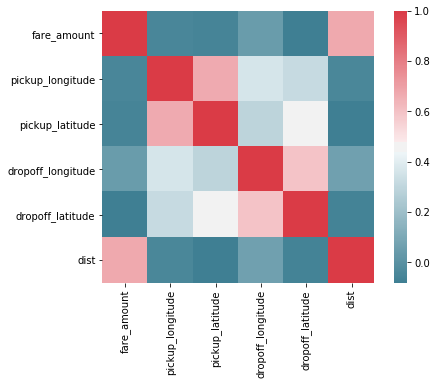

In [54]:
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = cab_corr.corr()
print(corr)
#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
#Remove all entires where the pickup and drop locations are same
cab=cab[np.logical_and(cab['pickup_longitude'] != cab['dropoff_longitude'], cab['pickup_latitude'] != cab['dropoff_latitude'])]

# Model Development

# Decision Tree

In [56]:
#Load libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [57]:
# Divide the data into train and test
train, test = train_test_split(cab, test_size=0.2)
# Already loaded

In [63]:
# Decision tree for regression
fit_DT = DecisionTreeRegressor(max_depth=2).fit(train.iloc[:, 1:7], train.iloc[:,0])

In [64]:
fit_DT

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [65]:
#Apply model on test data
predictions_DT = fit_DT.predict(test.iloc[:,1:7])


In [66]:
#Calculate MAPE
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

In [67]:
MAPE(test.iloc[:,0], predictions_DT)


29.71617460371191

In [ ]:
#Error 29.71

# Random Forest

In [68]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor



In [69]:
RF_model = RandomForestRegressor(n_estimators = 10).fit(train.iloc[:, 1:7], train.iloc[:,0])


In [70]:
RF_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [71]:
RF_Predictions = RF_model.predict(test.iloc[:, 1:7])

In [72]:
MAPE(test.iloc[:,0], RF_Predictions)

25.70792047195274

In [ ]:
#error is 25.71
#accuracy 75.29

# KNN Imputation

In [73]:
#KNN implementation
from sklearn.neighbors import KNeighborsRegressor

KNN_model = KNeighborsRegressor(n_neighbors = 1).fit(train.iloc[: , 1:7], train.iloc[:, 0])



In [74]:
#predict test cases
KNN_Predictions = KNN_model.predict(test.iloc[: , 1:7])


In [75]:
MAPE(test.iloc[:,0], KNN_Predictions)

34.58694638425659

In [ ]:
#error is 35.21
#accuracy is 65


# Linear Regression


In [76]:
value=['fare_amount', 'pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'dist']

In [77]:
linear = cab[value]


In [78]:
cat_names = ['passenger_count']
for i in cat_names:
    temp = pd.get_dummies(cab[i], prefix= i)
    linear = linear.join(temp)

In [81]:
#Import libraries for LR
import statsmodels.api as sm

In [82]:
# Train the model using the training sets
model = sm.OLS(train1.iloc[:, 0], train1.iloc[:, 1:12]).fit()

In [83]:
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     982.2
Date:                Fri, 07 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:04:17   Log-Likelihood:                -32527.
No. Observations:               11816   AIC:                         6.508e+04
Df Residuals:                   11805   BIC:                         6.516e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
pickup_longitude    -13.1754      3.054     -4.314      0.000     -19.162      -7.189
pickup_latitude       9.5117      2.353      4.042      0.000       4.899      14.124
dropoff_longitude    14.0406      2.693      5.214      0.000       8.762      19.319
dropoff_latitude    -16.1029      2.111     -7.627      0.000     -20.242     -11.964
dist                  1.9715      0.020     96.790      0.000       1.932       2.011
passenger_count_1   337.2362    341.174      0.988      0.323    -331.521    1005.994
passenger_count_2   337.3306    341.177      0.989      0.323    -331.432    1006.093
passenger_count_3   337.3130    341.179      0.989      0.323    -331.455    1006.081
passenger_count_4   337.1180    341.178      0.988      0.323    -331.647    1005.883
passenger_count_5   337.1729    341.176      0.988      0.323    -331.588    1005.933
passenger_count_6   338.1581    341.174      0.991      0.322    -330.599    1006.915
==============================================================================
Omnibus:                     6001.110   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44796.799
Skew:                           2.344   Prob(JB):                         0.00
Kurtosis:                      11.308   Cond. No.                     2.86e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [84]:
# make the predictions by the model
predictions_LR = model.predict(test1.iloc[:,1:31]) 


In [85]:
#Calculate MAPE
MAPE(test1.iloc[:,0], predictions_LR)

27.01811016316928

In [163]:
#MAPE 27.08

# Predict on new data

In [90]:
pred=(pd.read_csv('test.csv', header = 0 )).drop(columns="pickup_datetime")

In [91]:
#create Dist variable
pred['dist'] = \
    haversine( pred['pickup_latitude'], pred['pickup_longitude'],
                 pred['dropoff_latitude'], pred['dropoff_longitude'])

pred['fare_amount']=0
pred['passenger_count']=pred['passenger_count'].astype('category')

In [93]:
# Build model on the entire cab data
RF_model = RandomForestRegressor(n_estimators = 10).fit(cab.iloc[:, 1:7], cab.iloc[:,0])
#predict value
pred['fare_amount'] = RF_model.predict(pred.iloc[:, 0:6])